In [164]:
#%%
import numpy as np
import pandas as pd
import pickle
import os.path
import random
import category_encoders as ce

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [165]:

db_genba = pd.read_csv("train_genba.tsv",encoding="utf8",sep="\t")
db_goto = pd.read_csv("train_goto.tsv",encoding="utf8",sep="\t")

#%%
db = pd.merge(db_genba, db_goto, on='pj_no', how='left')

#%%
Y = db["keiyaku_pr"]
X = db.drop(["keiyaku_pr"] ,axis=1)

In [166]:
levelplan_df = X['levelplan'].str.split('[/]',expand=True)
X[["levelplan1","levelplan2"]] =  levelplan_df[[0,1]]

X['resen_jr'] = X['rosen_nm1'].str.contains('JR')

jukyo_df = X['jukyo'].str.split('[市郡]',expand=True)
X[["jukyo1","jukyo2"]] =  jukyo_df[[0,1]]

In [167]:
X = X.drop(["levelplan","id","jukyo","pj_no"] ,axis=1)
X = X.fillna(0)
Y = Y.fillna(0)

#タイプがobject(文字列)の列list
list_cols = X.columns[X.dtypes == "object"]
list_cols = list(list_cols)

ce_oe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
X = ce_oe.fit_transform(X)
ETF_df = X

In [168]:
variable_num = 147

if os.path.exists("max_accuracy1.sav"):
    max_accuracy1 = pickle.load(open("max_accuracy1.sav","rb"))
else:
    max_accuracy1 = 100

if os.path.exists("max_accuracy2.sav"):
    max_accuracy2 = pickle.load(open("max_accuracy2.sav","rb"))
else:
    max_accuracy2 = 100

if os.path.exists("max_accuracy3.sav"):
    max_accuracy3 = pickle.load(open("max_accuracy3.sav","rb"))
else:
    max_accuracy3 = 100



print(max_accuracy1)
print(max_accuracy2)
print(max_accuracy3)

def cal_mape(A,B):
    return(np.sum(np.abs((A-B)/B))*(100/len(A)))

7.906663483994688
8.019790650847112
8.029876503873076


In [169]:
for n in range(1,101):
    print(str(n) + "回目")
    
    N_train = int(len(X.index) * 0.8)
    N_test = len(X.index) - N_train
    
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=N_test,shuffle = True)
    
    tuned_parameters = [{'n_estimators':[200,500]}]
    clf = GridSearchCV(
        RandomForestRegressor(),
        tuned_parameters,
        cv=4,
        scoring='neg_median_absolute_error'
    )
    
    clf.fit(X_train,list(Y_train))
    
    clf = clf.best_estimator_
    print(clf.n_estimators)
    
    
    #予想
    pred = clf.predict(X_test)
    
    #精度算出
    accuracy = cal_mape(pred,Y_test.values)
    
    
    #最高精度の情報を保存
    if accuracy < max_accuracy1:
        print("★精度更新★1")
        
        max_accuracy3 = max_accuracy2
        max_accuracy2 = max_accuracy1
        max_accuracy1 = accuracy
        
        if os.path.exists("max_accuracy1.sav"):
            
            if os.path.exists("max_accuracy2.sav"):
                #2番目を3番目に移動
                pickle.dump(pickle.load(open("max_accuracy2.sav","rb")),open("max_accuracy3.sav","wb"))
                pickle.dump(pickle.load(open("max_clf2.sav","rb")),open("max_clf3.sav","wb"))
                pickle.dump(pickle.load(open("max_X2.sav","rb")),open("max_X3.sav","wb"))
                
            #1番目を2番目に移動
            pickle.dump(pickle.load(open("max_accuracy1.sav","rb")),open("max_accuracy2.sav","wb"))
            pickle.dump(pickle.load(open("max_clf1.sav","rb")),open("max_clf2.sav","wb"))
            pickle.dump(pickle.load(open("max_X1.sav","rb")),open("max_X2.sav","wb"))
        
        #1番モデル保存
        pickle.dump(accuracy,open("max_accuracy1.sav","wb"))
        pickle.dump(clf,open("max_clf1.sav","wb"))
        pickle.dump(X,open("max_X1.sav","wb"))
    
    elif accuracy < max_accuracy2:
        print("★精度更新★2")
        
        max_accuracy3 = max_accuracy2
        max_accuracy2 = accuracy
        
        if os.path.exists("max_accuracy2.sav"):
            #2番目を3番目に移動
            pickle.dump(pickle.load(open("max_accuracy2.sav","rb")),open("max_accuracy3.sav","wb"))
            pickle.dump(pickle.load(open("max_clf2.sav","rb")),open("max_clf3.sav","wb"))
            pickle.dump(pickle.load(open("max_X2.sav","rb")),open("max_X3.sav","wb"))
        
        #2番モデル保存
        pickle.dump(accuracy,open("max_accuracy2.sav","wb"))
        pickle.dump(clf,open("max_clf2.sav","wb"))
        pickle.dump(X,open("max_X2.sav","wb"))
    
    elif accuracy < max_accuracy3:
        print("★精度更新★3")
        
        max_accuracy3 = accuracy
        
        #モデル保存
        pickle.dump(accuracy,open("max_accuracy3.sav","wb"))
        pickle.dump(clf,open("max_clf3.sav","wb"))
        pickle.dump(X,open("max_X3.sav","wb"))
    
    print(accuracy)
    
    #特徴量ランキングの作成
    features = X.columns
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    
    if 0 in importances:
        #特徴量が0の説明変数が存在する場合、0のものはすべて削除
        X = X.drop(columns=X.columns[importances == 0],axis=1) 
        print("説明変数削除")
    else:
        #それ以外の場合、特徴量の小さい順に説明変数を削除して説明変数の数をvariable_num以下にする
        count = 0
        while len(X.columns) + 5  > variable_num:
            X = X.drop(features[indices][count],axis=1)
            count += 1
            
        #ランダムに説明変数を1つ追加する
        while len(X.columns) <= variable_num:
            temp = random.randrange(len(ETF_df.columns))
            add_column = ETF_df.columns[temp]
            
            #既存のものとかぶらないように追加
            if add_column not in list(X.columns):
                X[add_column] = ETF_df[add_column]
        print("説明変数更新")
            
    X = X.fillna(0)
    print("-------------------------")

1回目
500
8.915473248780762
説明変数削除
-------------------------
2回目
200
8.75725850352813
説明変数更新
-------------------------
3回目
500
9.384928501612087
説明変数削除
-------------------------
4回目
500
8.214985482672827
説明変数更新
-------------------------
5回目
200
9.10537403050084
説明変数更新
-------------------------
6回目
500
9.054717684022204
説明変数更新
-------------------------
7回目
200
★精度更新★2
7.962652148053353
説明変数削除
-------------------------
8回目
500
★精度更新★1
7.812836302658252
説明変数更新
-------------------------
9回目
500
8.853133853988473
説明変数更新
-------------------------
10回目
200
9.573579416710782
説明変数更新
-------------------------
11回目
200
9.151736352652998
説明変数更新
-------------------------
12回目
500
8.080071538882311
説明変数更新
-------------------------
13回目
500
9.307039880733225
説明変数削除
-------------------------
14回目
500
9.207488692727791
説明変数更新
-------------------------
15回目
500
8.320929053457993
説明変数削除
-------------------------
16回目
200
8.310445458151596
説明変数更新
-------------------------
17回目
200
8.244265726281547
説明変数更新
-

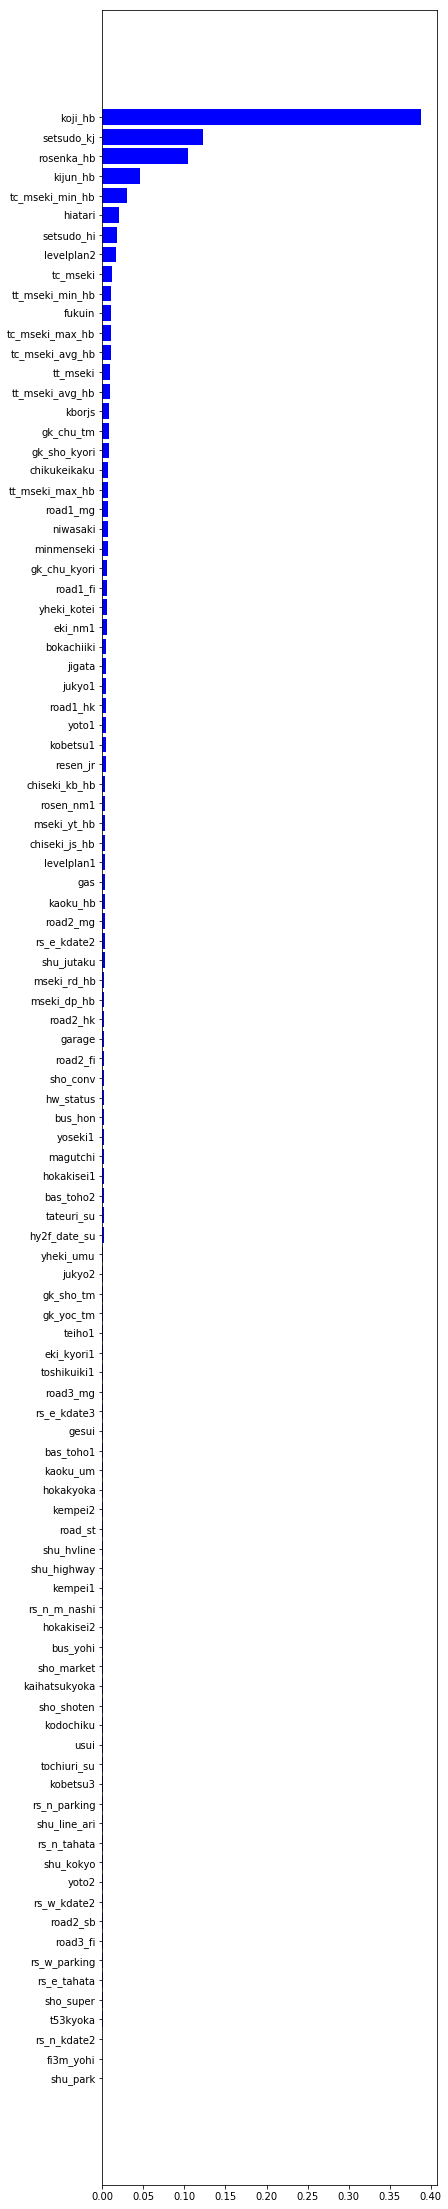

In [158]:
#特徴量確認
import matplotlib.pyplot as plt
%matplotlib inline

Xcolumns = X_train.columns
features = Xcolumns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,40))
plt.barh(range(len(indices)),importances[indices],color="b",align="center")
plt.yticks(range(len(indices)),features[indices])
plt.show()

In [137]:
importances[indices] > 0.001

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [146]:
X = pickle.load(open("max_X1.sav","rb"))

In [147]:
X

,chiseki_js_hb,chiseki_kb_hb,yoto1,yoseki1,gas,tateuri_su,hy2f_date_su,road1_hk,road1_fi,road1_mg,...,kobetsu2,fi4m_kyori,road2_sb,hokakisei3,rs_n_zoki,shu_bochi,road4_fi,road3_sb,kaihatsukyoka,toshikuiki2
0,109.26,109.10,1,200,1,1.0,1.0,1,4.0,7.0,...,1,0.0,1,1,1,1,0.0,1,1,1
1,136.15,136.00,2,200,1,1.0,1.0,2,4.2,9.3,...,1,0.0,2,1,1,1,0.0,1,1,1
2,86.92,86.52,2,100,1,1.0,1.0,3,4.0,11.1,...,1,0.0,3,1,1,1,0.0,1,1,1
3,164.91,164.07,1,200,2,1.0,1.0,4,4.0,13.3,...,1,0.0,2,1,1,1,0.0,1,1,1
4,403.58,403.58,2,80,2,3.0,3.0,5,4.0,13.9,...,1,0.0,1,2,1,1,0.0,1,1,1
5,403.58,403.58,2,80,2,3.0,3.0,5,4.0,13.9,...,1,0.0,1,2,1,1,0.0,1,1,1
6,403.58,403.58,2,80,2,3.0,3.0,5,4.0,13.9,...,1,0.0,1,2,1,1,0.0,1,1,1
7,114.44,114.55,3,200,2,1.0,1.0,2,4.0,11.2,...,2,0.0,3,1,1,1,0.0,1,1,1
8,531.98,498.06,4,200,1,0.0,0.0,5,16.4,23.6,...,1,0.0,3,1,1,1,0.0,1,2,1
9,531.98,498.06,4,200,1,0.0,0.0,5,16.4,23.6,...,3,0.0,3,1,1,1,0.0,1,2,1


In [233]:
tuned_parameters = [{'n_estimators':[50,100,200,300]}]
clf = GridSearchCV(
    RandomForestRegressor(),
    tuned_parameters,
    cv=4,
    scoring='neg_median_absolute_error',
    n_jobs=-1
)

clf.fit(X,list(Y))

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'n_estimators': [50, 100, 200, 3

In [150]:
X

,chiseki_js_hb,chiseki_kb_hb,yoto1,yoseki1,gas,tateuri_su,hy2f_date_su,road1_hk,road1_fi,road1_mg,...,kobetsu2,fi4m_kyori,road2_sb,hokakisei3,rs_n_zoki,shu_bochi,road4_fi,road3_sb,kaihatsukyoka,toshikuiki2
0,109.26,109.10,1,200,1,1.0,1.0,1,4.0,7.0,...,1,0.0,1,1,1,1,0.0,1,1,1
1,136.15,136.00,2,200,1,1.0,1.0,2,4.2,9.3,...,1,0.0,2,1,1,1,0.0,1,1,1
2,86.92,86.52,2,100,1,1.0,1.0,3,4.0,11.1,...,1,0.0,3,1,1,1,0.0,1,1,1
3,164.91,164.07,1,200,2,1.0,1.0,4,4.0,13.3,...,1,0.0,2,1,1,1,0.0,1,1,1
4,403.58,403.58,2,80,2,3.0,3.0,5,4.0,13.9,...,1,0.0,1,2,1,1,0.0,1,1,1
5,403.58,403.58,2,80,2,3.0,3.0,5,4.0,13.9,...,1,0.0,1,2,1,1,0.0,1,1,1
6,403.58,403.58,2,80,2,3.0,3.0,5,4.0,13.9,...,1,0.0,1,2,1,1,0.0,1,1,1
7,114.44,114.55,3,200,2,1.0,1.0,2,4.0,11.2,...,2,0.0,3,1,1,1,0.0,1,1,1
8,531.98,498.06,4,200,1,0.0,0.0,5,16.4,23.6,...,1,0.0,3,1,1,1,0.0,1,2,1
9,531.98,498.06,4,200,1,0.0,0.0,5,16.4,23.6,...,3,0.0,3,1,1,1,0.0,1,2,1


In [170]:
#clfから予想
clf = pickle.load(open("max_clf1.sav","rb"))
X = pickle.load(open("max_X1.sav","rb"))

db_genba_t = pd.read_csv("test_genba.tsv",encoding="utf8",sep="\t")
db_goto_t = pd.read_csv("test_goto.tsv",encoding="utf8",sep="\t")

merge_t = pd.merge(db_genba_t, db_goto_t, on='pj_no', how='left')


levelplan_df = merge_t['levelplan'].str.split('[/]',expand=True)
merge_t[["levelplan1","levelplan2"]] =  levelplan_df[[0,1]]

merge_t['resen_jr'] = merge_t['rosen_nm1'].str.contains('JR')

jukyo_df = merge_t['jukyo'].str.split('[市郡]',expand=True)
merge_t[["jukyo1","jukyo2"]] =  jukyo_df[[0,1]]

merge_t = merge_t.drop(["levelplan","id","jukyo","pj_no"] ,axis=1)


merge_t = ce_oe.transform(merge_t)

merge_t = merge_t.fillna(0)

merge_t = merge_t[X.columns]

pred_t = clf.predict(merge_t)
pred_t = np.round(pred_t)
print(pred_t)

[20284819. 26740855. 27033690. ... 30231022. 30006875. 27374645.]


In [249]:
db_genba_t = pd.read_csv("test_genba.tsv",encoding="utf8",sep="\t")
db_goto_t = pd.read_csv("test_goto.tsv",encoding="utf8",sep="\t")

#%%
X_t = pd.merge(db_genba_t, db_goto_t, on='pj_no', how='left')

X_t = ce_oe.fit_transform(X_t)
X_t = X_t.fillna(0)

In [250]:
X_t = X_t[X.columns]

In [251]:
pred_t = clf.predict(X_t)
pred_t = np.round(pred_t)
print(pred_t)

[20933333. 26539171. 27039211. ... 29985133. 29929466. 26015233.]


In [171]:
pred_t = pred_t.astype(np.int64)
print(pred_t)

[20284819 26740855 27033690 ... 30231022 30006875 27374645]


In [172]:
db_sample = pd.read_csv("sample_submit.tsv",encoding="utf8",sep="\t", names=('name', 'keiyaku_pr'))

In [173]:
db_sample["keiyaku_pr"] = pred_t

In [174]:
db_sample

,name,keiyaku_pr
0,test_0000,20284819
1,test_0001,26740855
2,test_0002,27033690
3,test_0003,27480540
4,test_0004,27706250
5,test_0005,26957890
6,test_0006,27499880
7,test_0007,27321550
8,test_0008,26813835
9,test_0009,28745478


In [175]:
db_sample.to_csv('sample_submit.tsv',header=False,index=False,sep="\t",line_terminator='\n')